# Max-Cut QAOA on QCS

In this notebook, we will walk through how to run the **Max-Cut QAOA** algorithm on the QPU and QVM. With **Parametric Compilation** and **Active Reset** enabled in QCS, we are able to achieve a **speedup of more than an order of magnitude** over web API offerings. The example below runs in less than a minute, as compared to more than 15 minutes using a web API. 

**NOTE**: This notebook depends on `pyquil >= 2.3.0`, `matplotlib`, and `tqdm`, which come preinstalled on all new QMIs.

In [1]:
from typing import List, Tuple

import networkx as nx
import numpy as np
from pyquil import get_qc, Program

## Generate Random Weighted Graph

Given a list of edges, we generate a graph with random edge weights in the range \[-1,1).

In [2]:
def generate_ising_graph(edges: List[Tuple[int, int]], seed: int) -> nx.Graph:
    np.random.seed(seed)
    graph = nx.from_edgelist(edges)
    weights:  np.ndarray = 2.0 * np.random.rand(graph.number_of_edges()) - 1.0
    weights /= np.linalg.norm(weights)
    nx.set_edge_attributes(graph, {e: {'w': w} for e, w in zip(graph.edges, weights)})
    return graph

## Compute Bitstring Cut Weight

Given a graph and a bitstring, compute the [cut weight](https://en.wikipedia.org/wiki/Maximum_cut), which determines the cost of the particular bitstring.

In [3]:
def bitstring_cut_weight(b: List[List[int]], graph: nx.Graph) -> dict:
    cost = 0
    inverse_map = {qubit: idx for idx, qubit in enumerate(list(graph.nodes))}
    for q0, q1 in graph.edges():
        cost += graph.get_edge_data(q0, q1)['w'] * (-1) ** int(b[inverse_map[q0]] != b[inverse_map[q1]])
    return cost

## Create QAOA Max-Cut Program

For our problem graph, we generate the [QAOA](https://arxiv.org/abs/1411.4028) cost and driver unitaries:

$$H_c = \sum_{i,j} w_{i,j} \sigma_i^z \sigma_j^z \qquad H_d = \sum_i \sigma_i^x$$

From these, we create our Quil program, using the [`exponential_map`](http://docs.rigetti.com/en/stable/advanced_usage.html#pauli-operator-algebra) function in pyQuil. As in the previous notebooks, we use the `RESET` instruction to enable **Active Reset** in our program, and declare our "beta" (β) and "gamma" (𝛾) values as parameters to leverage the **Parametric Compilation** feature. At the end of the program, we measure all qubits into the readout registers.

In [4]:
from pyquil.gates import H, MEASURE, RESET
from pyquil.paulis import exponential_map, PauliSum, sX, sZ

def maxcut_qaoa_program(graph: nx.Graph) -> Program:
    cost_ham = PauliSum([sZ(i) * sZ(j) * graph.get_edge_data(i, j)['w'] for i, j in graph.edges])
    driver_ham = PauliSum([sX(i) for i in graph.nodes])

    p = Program(RESET())
    beta = p.declare('beta', 'REAL')
    gamma = p.declare('gamma', 'REAL')
    ro = p.declare('ro', 'BIT', len(graph.nodes))

    p.inst(H(qubit) for qubit in list(graph.nodes))
    p.inst(exponential_map(term)(gamma) for term in cost_ham)
    p.inst(exponential_map(term)(beta) for term in driver_ham)

    p.inst(MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(list(graph.nodes)))
    return p

## Run the Landscape

Given a list of edges and a QPU- or QVM-backed `QuantumComputer` object, generate the Max-Cut QAOA program, compile it to a parametric binary, and rapidly iterate through the landscape of (β, 𝛾). For each job, we compute the average cost, which will become the $z$-axis of the landscape.

In [5]:
import itertools
from tqdm import tqdm
from pyquil.api import QPU, QuantumComputer

def run_maxcut_qaoa_landscape(qc: QuantumComputer, edges: List[Tuple[int, int]], width: int,
                              shots: int = 1000, seed: int = 19120623) -> np.ndarray:
    qc.reset()
    graph = generate_ising_graph(edges, seed)
    p = maxcut_qaoa_program(graph)
    p.wrap_in_numshots_loop(shots)
    binary = qc.compile(p) if isinstance(qc.qam, QPU) else p

    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range))
    for beta, gamma in tqdm(landscape):
        bitstrings = qc.run(binary, memory_map={'beta': [beta], 'gamma': [gamma]})
        costs.append(np.mean([bitstring_cut_weight(list(b), graph) for b in bitstrings]))

    return np.array(costs).reshape(width, width)

## Plot the Landscape

Given results from running QAOA, plot the landscape and the max cost value (shown as a red dot).

In [6]:
import matplotlib.pyplot as plt

def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.colorbar()
    plt.xlabel('gamma (radians)')
    plt.ylabel('beta (radians)')
    plt.title(f'Max-Cut QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()

## Device Information

As in the **Parametric Compilation** and **Active Qubit Reset** notebooks, we must start by setting up the device or devices that we want to run on. In this notebook, we want to execute our algorithm on both the QPU and the QVM, and compare our results. We will use the `Aspen-3-3Q-B` lattice for the [QPU](https://www.rigetti.com/qpu) and a generic `3q-qvm` for our simulator. The `qvm` is our Quantum Virtual Machine, and is also available as part of the downloadable [Forest SDK](https://www.rigetti.com/forest). 

**NOTE**: When running this notebook, you may need to edit the entries to `get_qc` in the following cell and the `edges` entry in the cell after, depending on what QPU lattice you have booked. And remember that this code will only work from within the QMI!

In [7]:
qpu = get_qc('Aspen-3-3Q-B')  # edit as necessary
qvm = get_qc('3q-qvm')  # edit as necessary

## Landscape Information

In addition to providing the device that we want to run on, we need to provide some more information to build our QAOA landscape. The `width` parameter sets the resolution of the landscape—the width squared is the number of jobs we will run. The `shots` parameter specifies how many repetitions to perform for each (β, 𝛾) angle pair. The `seed` parameter is used when randomly generating the edge weights of our graph, and we can reproduce the same graph by keeping the seed constant. Finally, the `edges` specify the qubits and the topology of the graph that we will run QAOA on. For this example, we use a line graph, but you can create more interesting topologies by changing the edge list.

In [8]:
width = 25
shots = 1000
seed = 19120623
edges = [(1, 2), (2, 3)]  # edit as necessary

## Run and Plot on QPU and QVM

We run the QAOA algorithm on the QPU and the QVM, comparing the max value of each landscape, which should be nearly the same. Small differences can be attributed to gate infidelity and decoherence, and larger ones can come from the presence of more than one "peak" in the landscape (as seen by the presence of multiple yellow blobs). We can also see that for this 3Q instance that the QVM outperforms the QPU in terms of total execution time. However, for larger numbers of qubits, the QPU quickly becomes much more efficient at completing the grid search.

100%|██████████| 625/625 [00:26<00:00, 23.72it/s]


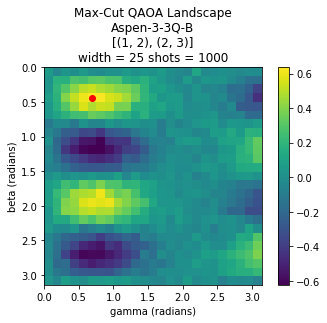

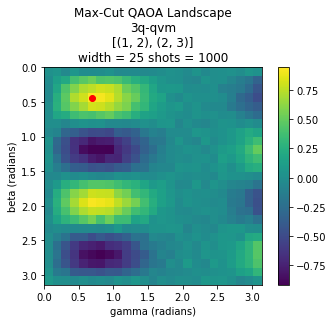

In [9]:
landscape_qpu = run_maxcut_qaoa_landscape(qpu, edges, width, shots, seed)
landscape_qvm = run_maxcut_qaoa_landscape(qvm, edges, width, shots, seed)
plot_landscape(landscape_qpu, device=qpu.name, edges=edges, width=width, shots=shots)
plot_landscape(landscape_qvm, device=qvm.name, edges=edges, width=width, shots=shots)